**1. Data Loading & Initial Inspection**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split,TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import joblib
import pickle
import json
import os
from datetime import datetime
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.metrics import explained_variance_score

# Load the data
df = pd.read_csv('commodity_prices.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nDate Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nColumns ({len(df.columns)}):")
print(df.columns.tolist())

Dataset Shape: (429, 65)

Date Range: 1990-01-01 to 2025-09-01

Columns (65):
['Date', 'All Commodity Price Index', 'Non-Fuel Price Index', 'Food and Beverage Price Index', 'Food Price Index', 'Beverage Price Index', 'Industrial Inputs Price Index', 'Agricultural Raw Materials Index', 'Metals Price Index', 'Fuel Energy Index', 'Crude Oil petroleum', 'Aluminum', 'Bananas', 'Barley', 'Beef', 'Coal', 'Cocoa beans', 'Coffee Other Mild Arabicas', 'Coffee Robusta', 'Rapeseed oil', 'Copper', 'Cotton', 'Fishmeal', 'Groundnuts peanuts', 'Hides', 'China import Iron Ore Fines 62% FE spot', 'Lamb', 'Lead', 'Soft Logs', 'Hard Logs', 'Maize corn', 'Natural Gas - Russian Natural Gas border price in Germany', 'Natural Gas - Indonesian Liquefied Natural Gas in Japan', 'Natural Gas - Spot price at the Henry Hub terminal in Louisiana', 'Nickel', 'Crude Oil - petroleum-simple average of three spot prices', 'Crude Oil - petroleum - Dated Brent light blend', 'Oil Dubai', 'Crude Oil petroleum - West Texas In

**2. Data Cleaning & Preprocessing**

In [3]:
# Check missing values
missing_values = df.isnull().sum()
missing_pct = (missing_values / len(df)) * 100

print("Columns with missing values:")
print(missing_pct[missing_pct > 0].sort_values(ascending=False))

# Ensure 'Date' is available as a column (handle case where it is already the index)
if 'Date' not in df.columns:
    # If the index is a DatetimeIndex or named 'Date', reset index to a 'Date' column
    if isinstance(df.index, pd.DatetimeIndex) or df.index.name == 'Date':
        df = df.reset_index()
        if 'Date' not in df.columns:
            df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
    else:
        # try to locate a column that contains date-like data
        date_candidates = [c for c in df.columns if 'date' in c.lower()]
        if date_candidates:
            df.rename(columns={date_candidates[0]: 'Date'}, inplace=True)
        else:
            raise KeyError("Could not find a 'Date' column or a 'Date' index in the dataframe.")

# Convert Date to datetime and sort
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
if df['Date'].isnull().any():
    print("Warning: Some Date values could not be parsed and became NaT.")

df = df.sort_values('Date').reset_index(drop=True)

# Set Date as index
df.set_index('Date', inplace=True)

# Forward fill for minor missing values, then backward fill
df = df.fillna(method='ffill').fillna(method='bfill')

# Verify no missing values remain
print(f"Remaining missing values: {df.isnull().sum().sum()}")

print("\nData Types:")
print(df.dtypes.value_counts())

# Convert any object columns to numeric if possible (skip parsed complex column)
for col in df.select_dtypes(include=['object']).columns:
    if col == '__parsed_extra':
        continue
    try:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"Converted {col} to numeric")
    except Exception as e:
        print(f"Could not convert {col}: {e}")

Columns with missing values:
All Commodity Price Index           36.363636
Non-Fuel Price Index                36.363636
Food and Beverage Price Index       36.363636
Beef                                36.363636
Food Price Index                     5.594406
Beverage Price Index                 5.594406
Agricultural Raw Materials Index     5.594406
Metals Price Index                   5.594406
Crude Oil petroleum                  5.594406
Aluminum                             5.594406
Barley                               5.594406
Coal                                 5.594406
Coffee Other Mild Arabicas           5.594406
Palm oil                             5.594406
Cocoa beans                          2.797203
Swine - pork                         2.797203
dtype: float64
Remaining missing values: 0

Data Types:
float64    63
object      1
Name: count, dtype: int64


**3. Exploratory Data Analysis (EDA)**

*3.1 Basic Statistics*

In [4]:
# Summary statistics for major commodity categories
major_categories = [
    'All Commodity Price Index',
    'Crude Oil - petroleum-simple average of three spot prices',
    'Copper',
    'Wheat',
    'Natural Gas - Spot price at the Henry Hub terminal in Louisiana',
    'Gold'  # Note: Check if gold exists in data
]

# Filter available categories
available_cats = [cat for cat in major_categories if cat in df.columns]

print("Summary Statistics for Major Commodities:")
print(df[available_cats].describe())

Summary Statistics for Major Commodities:
       All Commodity Price Index  \
count                 429.000000   
mean                  110.279871   
std                    45.568851   
min                    61.885186   
25%                    65.151363   
50%                   105.672052   
75%                   154.194472   
max                   241.934979   

       Crude Oil - petroleum-simple average of three spot prices       Copper  \
count                                         429.000000           429.000000   
mean                                          129.748976           794.790191   
std                                            23.924246           343.418788   
min                                            81.992306           250.510000   
25%                                           110.779212           494.098443   
50%                                           125.999213           790.745856   
75%                                           150.354390          

*3.2 Time Series Visualization*

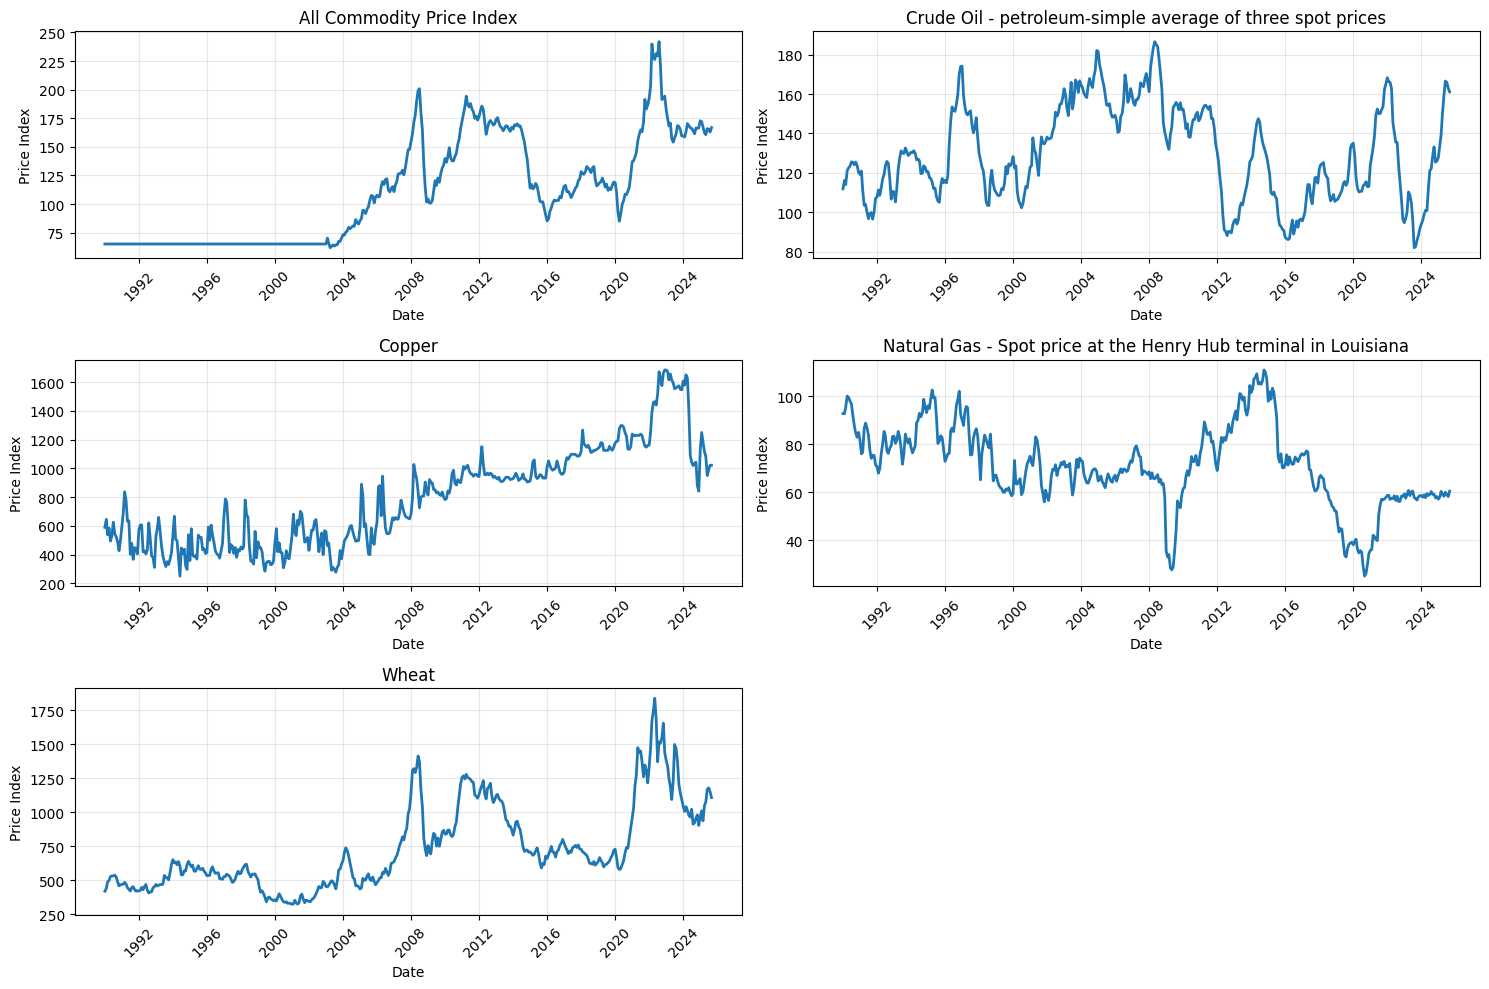

In [5]:
plt.figure(figsize=(15, 10))

# Plot major commodity indices
plot_cols = [
    'All Commodity Price Index',
    'Crude Oil - petroleum-simple average of three spot prices',
    'Copper',
    'Natural Gas - Spot price at the Henry Hub terminal in Louisiana',
    'Wheat'
]

for i, col in enumerate(plot_cols, 1):
    if col in df.columns:
        plt.subplot(3, 2, i)
        plt.plot(df.index, df[col], label=col, linewidth=2)
        plt.title(col)
        plt.xlabel('Date')
        plt.ylabel('Price Index')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

*3.3 Correlation Analysis*

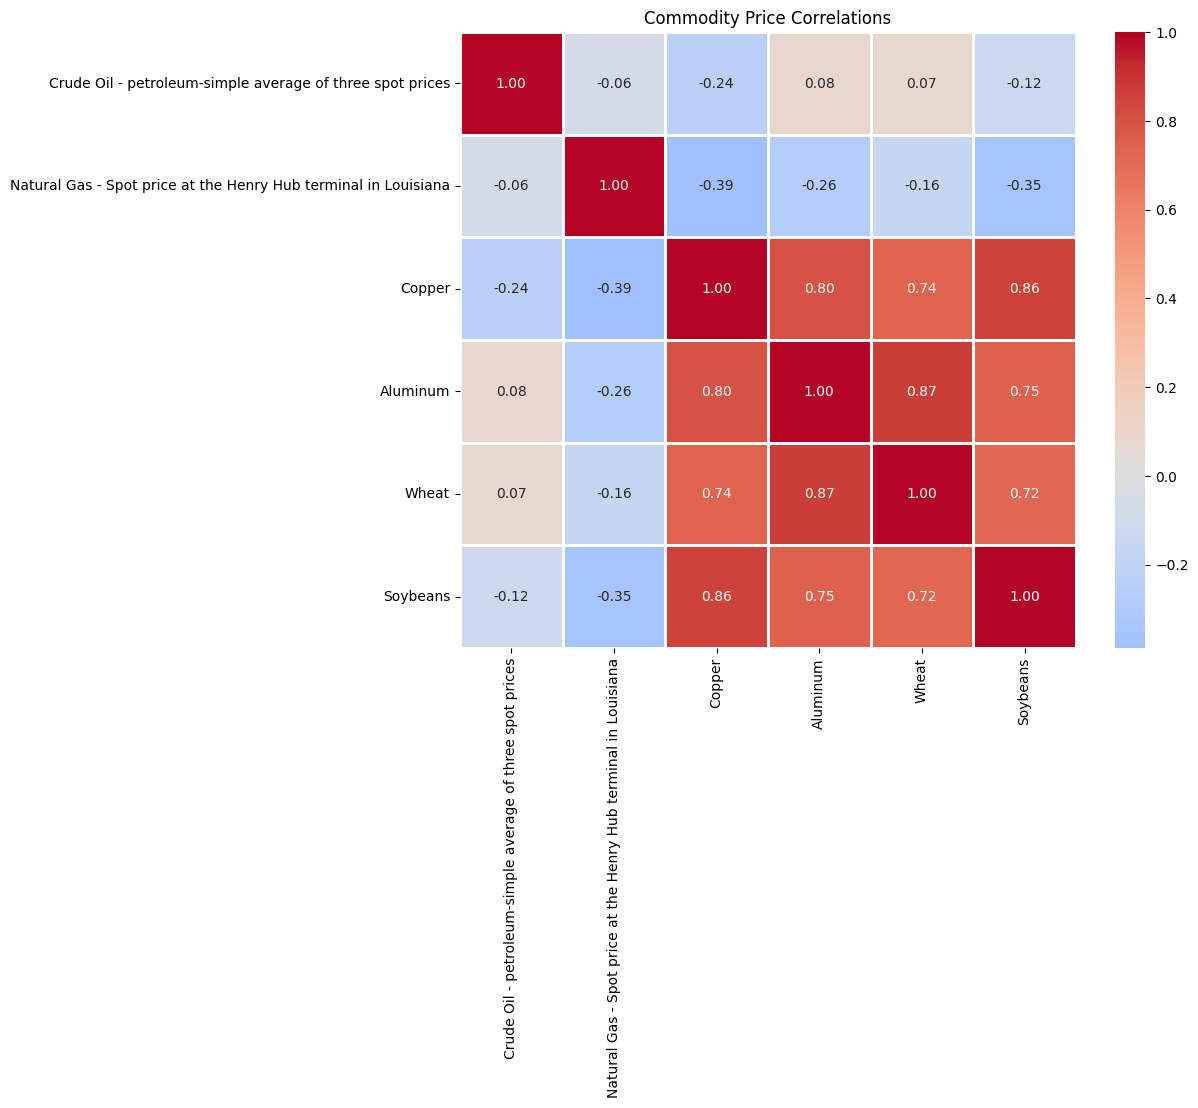

In [6]:
# Select key commodities for correlation analysis
key_commodities = [
    'Crude Oil - petroleum-simple average of three spot prices',
    'Natural Gas - Spot price at the Henry Hub terminal in Louisiana',
    'Copper',
    'Aluminum',
    'Wheat',
    'Soybeans',
    'Gold'
]

# Filter to available columns
available_keys = [col for col in key_commodities if col in df.columns]

# Calculate correlation matrix
corr_matrix = df[available_keys].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Commodity Price Correlations')
plt.show()

**4. Feature Engineering**

*4.1 Create Lag Features*

In [7]:
def create_lag_features(data, column, lags=[1, 2, 3, 6, 12]):
    """Create lag features for time series forecasting"""
    for lag in lags:
        data[f'{column}_lag_{lag}'] = data[column].shift(lag)
    return data

# Select target commodity (Crude Oil as example)
target_commodity = 'Crude Oil - petroleum-simple average of three spot prices'

# Create lag features for the target
df = create_lag_features(df, target_commodity, lags=[1, 2, 3, 4, 5, 6])

# Create rolling statistics
df[f'{target_commodity}_rolling_mean_3'] = df[target_commodity].rolling(window=3).mean()
df[f'{target_commodity}_rolling_std_3'] = df[target_commodity].rolling(window=3).std()

# Create month and year features
df['month'] = df.index.month
df['year'] = df.index.year

*4.2 Create Technical Indicators*

In [8]:
# Simple Moving Average
df[f'{target_commodity}_SMA_3'] = df[target_commodity].rolling(window=3).mean()
df[f'{target_commodity}_SMA_6'] = df[target_commodity].rolling(window=6).mean()

# Rate of Change
df[f'{target_commodity}_ROC_1'] = df[target_commodity].pct_change(periods=1)
df[f'{target_commodity}_ROC_3'] = df[target_commodity].pct_change(periods=3)

# Remove rows with NaN from lag features
df_clean = df.dropna().copy()

**5. Model Training**

*5.1 Prepare Data for ML*

In [9]:
# Define features and target
feature_columns = [
    f'{target_commodity}_lag_1',
    f'{target_commodity}_lag_2', 
    f'{target_commodity}_lag_3',
    f'{target_commodity}_rolling_mean_3',
    f'{target_commodity}_ROC_1',
    f'{target_commodity}_SMA_3',
    'month',
    'All Commodity Price Index'  # Add broader market indicator
]

# Filter to available features
available_features = [col for col in feature_columns if col in df_clean.columns]

X = df_clean[available_features]
y = df_clean[target_commodity]

# Split data (chronological split)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 338
Testing samples: 85


*5.2 Train Multiple Models*

In [10]:
print("=" * 70)
print("🎯 ADVANCED TREE-BASED MODELS WITH HYPERPARAMETER TUNING")
print("=" * 70)

# Ensure we have the data prepared
print(f"\n📊 Dataset Shape: {X_train.shape}")
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

🎯 ADVANCED TREE-BASED MODELS WITH HYPERPARAMETER TUNING

📊 Dataset Shape: (338, 8)
Training samples: 338, Testing samples: 85



ENSEMBLE MODELS WITH ENHANCED REGULARIZATION AND CROSS-VALIDATION

📊 Using Enhanced TimeSeriesSplit:
   • Number of folds: 5
   • Test size per fold: 6 months
   • Gap between train/test: 3 months
   • Total validation samples: ~30 months

TRAINING RANDOM FOREST WITH REGULARIZATION

Performing RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Random Forest tuning complete!
Best Parameters: {'oob_score': True, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0, 'max_features': 'log2', 'max_depth': 7, 'ccp_alpha': 0.01, 'bootstrap': True}
Best CV Score (MSE): 8.9433

📈 CV Performance Analysis:
Mean Train MSE: 14.4279
Mean Validation MSE: 20.6808
Mean Gap: -6.2528

📊 Enhanced Random Forest Performance:

📊 Random Forest Enhanced (Train) Performance Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):      1.6155
MSE (Mean Squared Error):       5

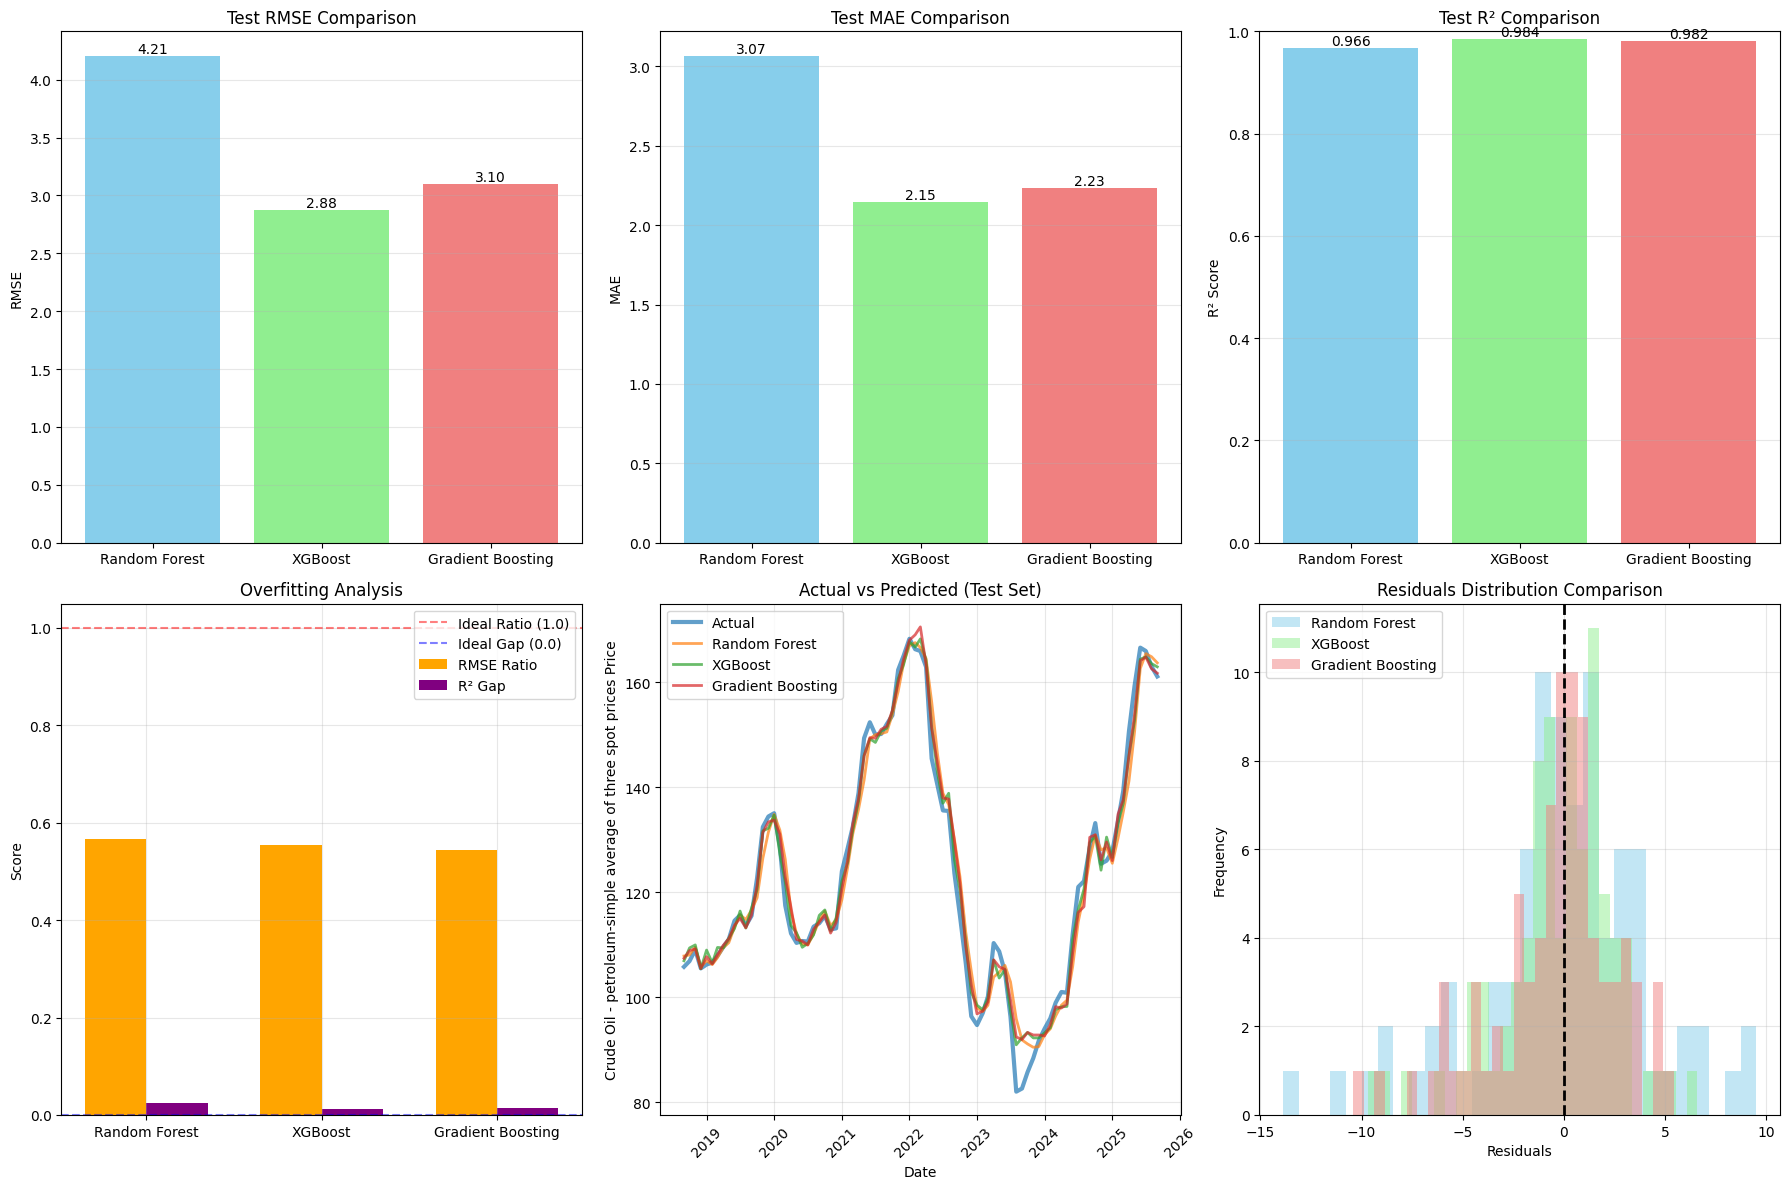

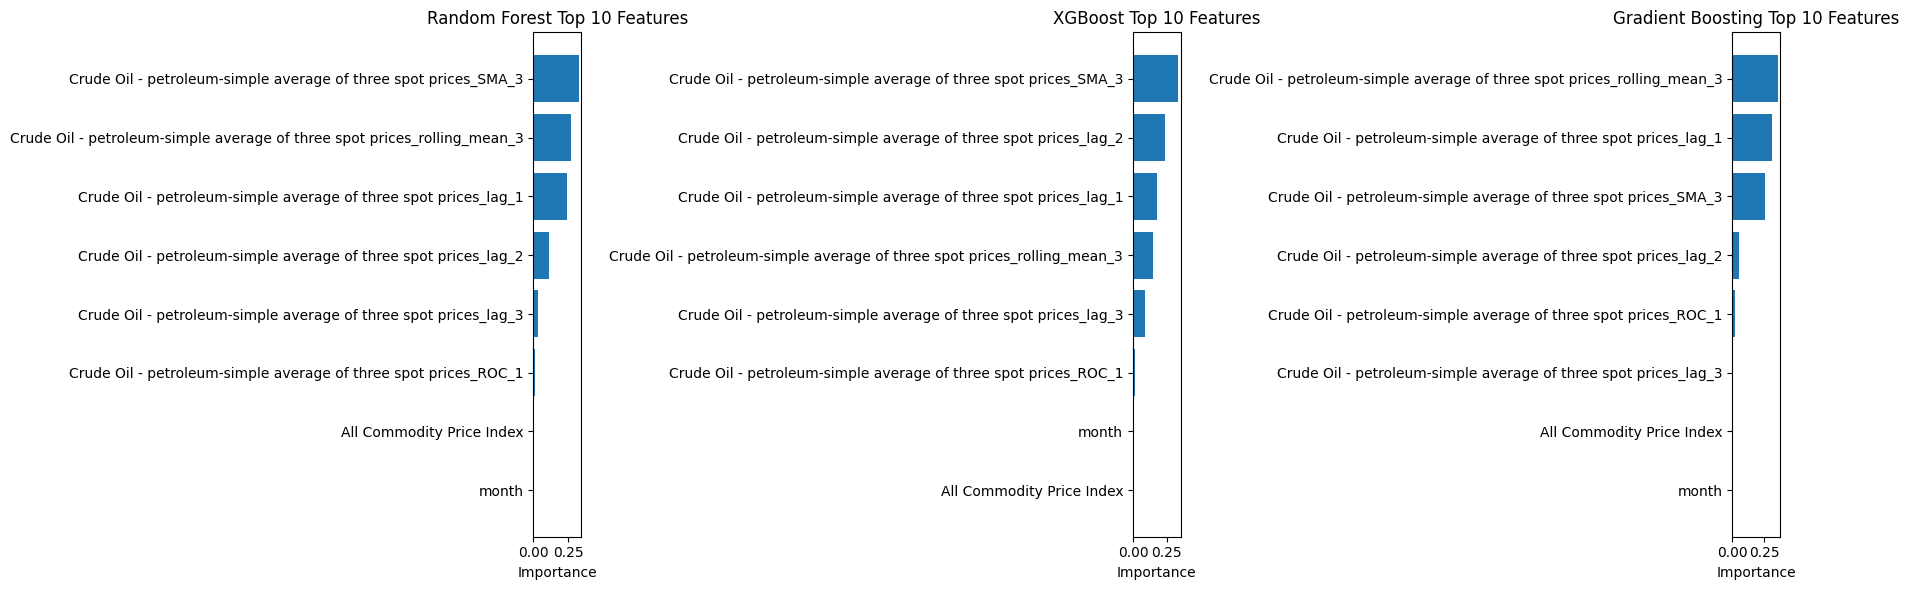


ENSEMBLE MODEL CONSTRUCTION

📊 Ensemble Weights (based on RMSE):
  Random Forest: 0.262
  XGBoost: 0.383
  Gradient Boosting: 0.356

📈 Ensemble Model Performance:

📊 Ensemble Model Performance Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):      2.3298
MSE (Mean Squared Error):       10.1287
RMSE (Root Mean Squared Error): 3.1826
R² Score:                        0.9808
MAPE (Mean Absolute % Error):   2.02%
MASE (Mean Absolute Scaled Error): 0.5490
Explained Variance:             0.9810
Max Error:                      10.7563
Median Absolute Error:          1.6286
Correlation:                    0.9908
Bias (Predicted - Actual):      0.2943
Predictions within 5% tolerance: 91.8%
Predictions within 10% tolerance: 97.6%
95% Prediction Interval Coverage: 94.1%
Directional Accuracy:            85.7%
Mean Actual Value:              123.5384
Mean Predicted Value:           123.8327
Std Actual:                     22.9708
Std Predicted:        

In [14]:
# ============================================================================
# MODEL TRAINING WITH ENHANCED REGULARIZATION AND CROSS-VALIDATION
# ============================================================================

print("\n" + "="*80)
print("ENSEMBLE MODELS WITH ENHANCED REGULARIZATION AND CROSS-VALIDATION")
print("="*80)

# ============================================================================
# ENHANCED CROSS-VALIDATION STRATEGY
# ============================================================================


# Create robust time series cross-validation
tscv_robust = TimeSeriesSplit(
    n_splits=5,
    test_size=6,  # Test on 6 months
    gap=3,  # 3-month gap to prevent data leakage
    max_train_size=None
)

print(f"\n📊 Using Enhanced TimeSeriesSplit:")
print(f"   • Number of folds: {tscv_robust.n_splits}")
print(f"   • Test size per fold: {tscv_robust.test_size} months")
print(f"   • Gap between train/test: {tscv_robust.gap} months")
print(f"   • Total validation samples: ~{tscv_robust.n_splits * tscv_robust.test_size} months")

def evaluate_model(y_true, y_pred, model_name, print_results=True):

    # Convert to numpy arrays if not already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Ensure arrays have same length
    if len(y_true) != len(y_pred):
        raise ValueError(f"y_true (length={len(y_true)}) and y_pred (length={len(y_pred)}) must have same length")
    
    # Calculate basic metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    # Avoid division by zero
    mask = y_true != 0
    if np.any(mask):
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    # Calculate Mean Absolute Scaled Error (MASE)
    # MASE = MAE / MAE_naive, where naive forecast is previous value
    if len(y_true) > 1:
        mae_naive = mean_absolute_error(y_true[1:], y_true[:-1])
        mase = mae / mae_naive if mae_naive != 0 else np.nan
    else:
        mase = np.nan
    
    # Calculate Explained Variance Score
    explained_variance = explained_variance_score(y_true, y_pred)
    
    # Calculate Max Error
    max_error_val = np.max(np.abs(y_true - y_pred))
    
    # Calculate Median Absolute Error
    median_ae = np.median(np.abs(y_true - y_pred))
    
    # Calculate correlation coefficient
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    
    # Calculate percentage within tolerance
    tolerance_5pct = np.mean(np.abs(y_true - y_pred) <= 0.05 * np.abs(y_true)) * 100
    tolerance_10pct = np.mean(np.abs(y_true - y_pred) <= 0.10 * np.abs(y_true)) * 100
    
    # Calculate Directional Accuracy (for time series)
    if len(y_true) > 1:
        # Calculate direction of actual and predicted changes
        actual_changes = np.diff(y_true) > 0
        predicted_changes = np.diff(y_pred) > 0
        directional_accuracy = np.mean(actual_changes == predicted_changes) * 100
    else:
        directional_accuracy = np.nan
    
    # Calculate prediction interval coverage
    # Assuming 95% confidence interval based on residuals
    residuals = y_true - y_pred
    std_residuals = np.std(residuals)
    lower_bound = y_pred - 1.96 * std_residuals
    upper_bound = y_pred + 1.96 * std_residuals
    coverage_95 = np.mean((y_true >= lower_bound) & (y_true <= upper_bound)) * 100
    
    # Create comprehensive metrics dictionary
    metrics = {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'MASE': mase,
        'Explained Variance': explained_variance,
        'Max Error': max_error_val,
        'Median AE': median_ae,
        'Correlation': correlation,
        'Tolerance 5%': tolerance_5pct,
        'Tolerance 10%': tolerance_10pct,
        'Directional Accuracy': directional_accuracy,
        '95% Coverage': coverage_95,
        'Sample Size': len(y_true),
        'Residual Std': std_residuals,
        'Mean Actual': np.mean(y_true),
        'Mean Predicted': np.mean(y_pred),
        'Std Actual': np.std(y_true),
        'Std Predicted': np.std(y_pred),
        'Bias': np.mean(y_pred - y_true)  # Positive = overestimation, negative = underestimation
    }
    
    # Print results if requested
    if print_results:
        print(f"\n📊 {model_name} Performance Metrics:")
        print("-" * 60)
        
        # Basic metrics
        print(f"MAE (Mean Absolute Error):      {mae:.4f}")
        print(f"MSE (Mean Squared Error):       {mse:.4f}")
        print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
        print(f"R² Score:                        {r2:.4f}")
        
        # Percentage metrics
        if not np.isnan(mape):
            print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")
        if not np.isnan(mase):
            print(f"MASE (Mean Absolute Scaled Error): {mase:.4f}")
        
        # Statistical metrics
        print(f"Explained Variance:             {explained_variance:.4f}")
        print(f"Max Error:                      {max_error_val:.4f}")
        print(f"Median Absolute Error:          {median_ae:.4f}")
        print(f"Correlation:                    {correlation:.4f}")
        print(f"Bias (Predicted - Actual):      {metrics['Bias']:.4f}")
        
        # Coverage metrics
        print(f"Predictions within 5% tolerance: {tolerance_5pct:.1f}%")
        print(f"Predictions within 10% tolerance: {tolerance_10pct:.1f}%")
        print(f"95% Prediction Interval Coverage: {coverage_95:.1f}%")
        
        # Directional accuracy for time series
        if not np.isnan(directional_accuracy):
            print(f"Directional Accuracy:            {directional_accuracy:.1f}%")
        
        # Summary statistics
        print(f"Mean Actual Value:              {np.mean(y_true):.4f}")
        print(f"Mean Predicted Value:           {np.mean(y_pred):.4f}")
        print(f"Std Actual:                     {np.std(y_true):.4f}")
        print(f"Std Predicted:                  {np.std(y_pred):.4f}")
        print(f"Residual Standard Deviation:    {std_residuals:.4f}")
        print(f"Number of Samples:              {len(y_true)}")
        
        print("-" * 60)
    
    return metrics
# ============================================================================
# CUSTOM SCORING FUNCTION WITH OVERFITTING PENALTY
# ============================================================================



def robust_scorer(y_true, y_pred, X_train=None, model=None, alpha=0.1):
    """
    Custom scoring function that penalizes:
    1. Prediction errors (RMSE)
    2. Overfitting (gap between train and validation performance)
    3. Model complexity
    """
    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    # Add small penalty for model complexity if model is provided
    complexity_penalty = 0
    if model is not None:
        if hasattr(model, 'n_estimators'):
            complexity_penalty = model.n_estimators * 0.0001
        if hasattr(model, 'max_depth') and model.max_depth is not None:
            complexity_penalty += model.max_depth * 0.001
    
    # Combine scores with complexity penalty
    score = rmse * (1 + complexity_penalty)
    
    return -score  # Negative because GridSearchCV maximizes

# Create scorer for cross-validation
custom_scorer = make_scorer(robust_scorer, greater_is_better=False)

# ============================================================================
# 1. RANDOM FOREST WITH ENHANCED REGULARIZATION
# ============================================================================

print("\n" + "="*60)
print("TRAINING RANDOM FOREST WITH REGULARIZATION")
print("="*60)

# Enhanced parameter grid for Random Forest
rf_param_grid_enhanced = {
    # Model complexity - keep it simple
    'n_estimators': [50, 80, 100],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [5, 10, 15],
    
    # Feature and sample subsampling
    'max_features': [0.3, 0.5, 'sqrt', 'log2'],
    'bootstrap': [True],
    'oob_score': [True],  # Use out-of-bag score for better generalization
    
    # Regularization
    'min_impurity_decrease': [0.0, 0.01, 0.05],
    'ccp_alpha': [0.0, 0.001, 0.01],  # Cost complexity pruning
}

# Initialize Random Forest with conservative settings
rf_base = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    warm_start=False,
    verbose=0
)

# Use RandomizedSearchCV with more iterations
print("\nPerforming RandomizedSearchCV for Random Forest...")
rf_random_enhanced = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_grid_enhanced,
    n_iter=30,  # More iterations
    cv=tscv_robust,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=2,
    refit=True,
    return_train_score=True
)

# Fit the model
rf_random_enhanced.fit(X_train_scaled, y_train)
print(f"\n✅ Random Forest tuning complete!")
print(f"Best Parameters: {rf_random_enhanced.best_params_}")
print(f"Best CV Score (MSE): {-rf_random_enhanced.best_score_:.4f}")

# Analyze training vs validation performance
train_scores_rf = -rf_random_enhanced.cv_results_['mean_train_score']
test_scores_rf = -rf_random_enhanced.cv_results_['mean_test_score']
print(f"\n📈 CV Performance Analysis:")
print(f"Mean Train MSE: {np.mean(train_scores_rf):.4f}")
print(f"Mean Validation MSE: {np.mean(test_scores_rf):.4f}")
print(f"Mean Gap: {np.mean(train_scores_rf - test_scores_rf):.4f}")

# Get best model
best_rf_enhanced = rf_random_enhanced.best_estimator_

# Predictions
y_pred_rf_train_enhanced = best_rf_enhanced.predict(X_train_scaled)
y_pred_rf_test_enhanced = best_rf_enhanced.predict(X_test_scaled)

# Evaluate
print("\n📊 Enhanced Random Forest Performance:")
rf_train_metrics_enhanced = evaluate_model(y_train, y_pred_rf_train_enhanced, "Random Forest Enhanced (Train)")
rf_test_metrics_enhanced = evaluate_model(y_test, y_pred_rf_test_enhanced, "Random Forest Enhanced (Test)")

# Calculate overfitting metrics
rf_overfit_ratio = rf_train_metrics_enhanced['RMSE'] / rf_test_metrics_enhanced['RMSE']
rf_r2_gap = rf_train_metrics_enhanced['R2'] - rf_test_metrics_enhanced['R2']
print(f"\n🎯 Overfitting Analysis:")
print(f"Train/Test RMSE Ratio: {rf_overfit_ratio:.3f} (Ideal: ~1.0)")
print(f"R² Gap (Train - Test): {rf_r2_gap:.4f} (Ideal: <0.1)")

# ============================================================================
# 2. XGBOOST WITH ENHANCED REGULARIZATION
# ============================================================================

print("\n" + "="*60)
print("TRAINING XGBOOST WITH STRONG REGULARIZATION")
print("="*60)

# XGBoost parameter grid with strong regularization
xgb_param_grid_enhanced = {
    # Tree structure - shallow trees
    'max_depth': [2, 3, 4],
    'min_child_weight': [5, 10, 15],
    'gamma': [0.1, 0.3, 0.5, 1],  # Minimum loss reduction
    
    # Learning and regularization
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'n_estimators': [80, 100, 120],
    
    # Subsampling
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'colsample_bylevel': [0.7, 0.8, 0.9],
    'colsample_bynode': [0.7, 0.8, 0.9],
    
    # Regularization
    'reg_alpha': [0, 0.01, 0.1, 0.5],  # L1 regularization
    'reg_lambda': [1, 2, 5, 10],  # L2 regularization
    
    # Other
    'max_delta_step': [0, 1, 2],  # For imbalanced data
    'scale_pos_weight': [1]  # For regression
}

# Initialize XGBoost with conservative settings
xgb_base = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    objective='reg:squarederror',
    booster='gbtree',
    tree_method='auto',
    early_stopping_rounds=10,
    eval_metric='rmse'
)

print("\nPerforming RandomizedSearchCV for XGBoost...")
xgb_random_enhanced = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_grid_enhanced,
    n_iter=40,  # More iterations for XGBoost
    cv=tscv_robust,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=2,
    refit=True,
    return_train_score=True
)

# Fit with early stopping
xgb_random_enhanced.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

print(f"\n✅ XGBoost tuning complete!")
print(f"Best Parameters: {xgb_random_enhanced.best_params_}")
print(f"Best CV Score (MSE): {-xgb_random_enhanced.best_score_:.4f}")

# Get best model
best_xgb_enhanced = xgb_random_enhanced.best_estimator_

# Feature importance
xgb_importance = best_xgb_enhanced.feature_importances_
sorted_idx_xgb = np.argsort(xgb_importance)[::-1]

print("\n🔍 XGBoost Top 5 Feature Importances:")
for i in range(min(5, len(available_features))):
    print(f"  {i+1}. {available_features[sorted_idx_xgb[i]]}: {xgb_importance[sorted_idx_xgb[i]]:.4f}")

# Predictions
y_pred_xgb_train_enhanced = best_xgb_enhanced.predict(X_train_scaled)
y_pred_xgb_test_enhanced = best_xgb_enhanced.predict(X_test_scaled)

# Evaluate
print("\n📊 Enhanced XGBoost Performance:")
xgb_train_metrics_enhanced = evaluate_model(y_train, y_pred_xgb_train_enhanced, "XGBoost Enhanced (Train)")
xgb_test_metrics_enhanced = evaluate_model(y_test, y_pred_xgb_test_enhanced, "XGBoost Enhanced (Test)")

# Overfitting analysis
xgb_overfit_ratio = xgb_train_metrics_enhanced['RMSE'] / xgb_test_metrics_enhanced['RMSE']
xgb_r2_gap = xgb_train_metrics_enhanced['R2'] - xgb_test_metrics_enhanced['R2']
print(f"\n🎯 Overfitting Analysis:")
print(f"Train/Test RMSE Ratio: {xgb_overfit_ratio:.3f} (Ideal: ~1.0)")
print(f"R² Gap (Train - Test): {xgb_r2_gap:.4f} (Ideal: <0.1)")

# ============================================================================
# 3. GRADIENT BOOSTING WITH STRONG REGULARIZATION
# ============================================================================

print("\n" + "="*60)
print("TRAINING GRADIENT BOOSTING WITH STRONG REGULARIZATION")
print("="*60)

# Gradient Boosting parameter grid with strong regularization
gb_param_grid_enhanced = {
    # Conservative tree structure
    'max_depth': [2, 3],
    'min_samples_split': [15, 20, 25],
    'min_samples_leaf': [10, 15, 20],
    'max_features': [0.5, 0.6, 'sqrt'],
    'max_leaf_nodes': [20, 30, None],
    
    # Learning and regularization
    'learning_rate': [0.01, 0.02, 0.05],
    'n_estimators': [80, 100, 120],
    'subsample': [0.6, 0.7, 0.8],
    
    # Additional regularization
    'min_weight_fraction_leaf': [0.0, 0.05, 0.1],
    'min_impurity_decrease': [0.0, 0.001, 0.01],
    
    # Early stopping
    'validation_fraction': [0.1, 0.15],
    'n_iter_no_change': [5, 10],
    'tol': [1e-4, 1e-3]
}

# Initialize Gradient Boosting with conservative settings
gb_base = GradientBoostingRegressor(
    random_state=42,
    loss='squared_error',
    criterion='friedman_mse',
    init=None,
    verbose=0
)

print("\nPerforming RandomizedSearchCV for Gradient Boosting...")
gb_random_enhanced = RandomizedSearchCV(
    estimator=gb_base,
    param_distributions=gb_param_grid_enhanced,
    n_iter=35,
    cv=tscv_robust,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=2,
    refit=True,
    return_train_score=True
)

# Fit the model
gb_random_enhanced.fit(X_train_scaled, y_train)
print(f"\n✅ Gradient Boosting tuning complete!")
print(f"Best Parameters: {gb_random_enhanced.best_params_}")
print(f"Best CV Score (MSE): {-gb_random_enhanced.best_score_:.4f}")

# Analyze training vs validation
train_scores_gb = -gb_random_enhanced.cv_results_['mean_train_score']
test_scores_gb = -gb_random_enhanced.cv_results_['mean_test_score']
print(f"\n📈 CV Performance Analysis:")
print(f"Mean Train MSE: {np.mean(train_scores_gb):.4f}")
print(f"Mean Validation MSE: {np.mean(test_scores_gb):.4f}")
print(f"Mean Gap: {np.mean(train_scores_gb - test_scores_gb):.4f}")

# Get best model
best_gb_enhanced = gb_random_enhanced.best_estimator_

# Predictions
y_pred_gb_train_enhanced = best_gb_enhanced.predict(X_train_scaled)
y_pred_gb_test_enhanced = best_gb_enhanced.predict(X_test_scaled)

# Evaluate
print("\n📊 Enhanced Gradient Boosting Performance:")
gb_train_metrics_enhanced = evaluate_model(y_train, y_pred_gb_train_enhanced, "Gradient Boosting Enhanced (Train)")
gb_test_metrics_enhanced = evaluate_model(y_test, y_pred_gb_test_enhanced, "Gradient Boosting Enhanced (Test)")

# Overfitting analysis
gb_overfit_ratio = gb_train_metrics_enhanced['RMSE'] / gb_test_metrics_enhanced['RMSE']
gb_r2_gap = gb_train_metrics_enhanced['R2'] - gb_test_metrics_enhanced['R2']
print(f"\n🎯 Overfitting Analysis:")
print(f"Train/Test RMSE Ratio: {gb_overfit_ratio:.3f} (Ideal: ~1.0)")
print(f"R² Gap (Train - Test): {gb_r2_gap:.4f} (Ideal: <0.1)")

# ============================================================================
# MODEL COMPARISON AND VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Create comparison DataFrame
comparison_data = {
    'Model': ['Random Forest', 'XGBoost', 'Gradient Boosting'],
    'Test RMSE': [
        rf_test_metrics_enhanced['RMSE'],
        xgb_test_metrics_enhanced['RMSE'],
        gb_test_metrics_enhanced['RMSE']
    ],
    'Test MAE': [
        rf_test_metrics_enhanced['MAE'],
        xgb_test_metrics_enhanced['MAE'],
        gb_test_metrics_enhanced['MAE']
    ],
    'Test R²': [
        rf_test_metrics_enhanced['R2'],
        xgb_test_metrics_enhanced['R2'],
        gb_test_metrics_enhanced['R2']
    ],
    'Test MAPE': [
        rf_test_metrics_enhanced['MAPE'],
        xgb_test_metrics_enhanced['MAPE'],
        gb_test_metrics_enhanced['MAPE']
    ],
    'Overfitting Ratio': [
        rf_overfit_ratio,
        xgb_overfit_ratio,
        gb_overfit_ratio
    ],
    'R² Gap': [
        rf_r2_gap,
        xgb_r2_gap,
        gb_r2_gap
    ],
    'Model Complexity': [
        f"{best_rf_enhanced.n_estimators} trees",
        f"{best_xgb_enhanced.n_estimators} trees",
        f"{best_gb_enhanced.n_estimators_} trees"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 MODEL PERFORMANCE COMPARISON:")
print(comparison_df.to_string(index=False))

# Identify best model based on balanced performance
# Weigh both performance and generalization
weights = {
    'rmse_weight': 0.3,
    'r2_weight': 0.3,
    'overfitting_weight': 0.2,
    'mape_weight': 0.2
}

# Normalize scores
df_norm = comparison_df.copy()
for col in ['Test RMSE', 'Test MAE', 'Test MAPE', 'Overfitting Ratio', 'R² Gap']:
    if col in ['Test R²']:
        df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())
    else:
        df_norm[col] = 1 - (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())

# Calculate weighted score
df_norm['Weighted Score'] = (
    df_norm['Test RMSE'] * weights['rmse_weight'] +
    df_norm['Test R²'] * weights['r2_weight'] +
    df_norm['Overfitting Ratio'] * weights['overfitting_weight'] +
    (1 - df_norm['Test MAPE']) * weights['mape_weight']
)

best_model_idx = df_norm['Weighted Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']

print(f"\n🏆 BEST OVERALL MODEL: {best_model_name}")
print(f"   Weighted Score: {df_norm.loc[best_model_idx, 'Weighted Score']:.3f}")
print(f"   Test RMSE: {comparison_df.loc[best_model_idx, 'Test RMSE']:.4f}")
print(f"   Test R²: {comparison_df.loc[best_model_idx, 'Test R²']:.4f}")
print(f"   Overfitting Ratio: {comparison_df.loc[best_model_idx, 'Overfitting Ratio']:.3f}")

# Store best model
best_model_enhanced = {
    'Random Forest': best_rf_enhanced,
    'XGBoost': best_xgb_enhanced,
    'Gradient Boosting': best_gb_enhanced
}[best_model_name]

# ============================================================================
# VISUALIZATIONS
# ============================================================================

# 1. Model Performance Comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: RMSE Comparison
models = comparison_df['Model']
rmse_values = comparison_df['Test RMSE']
mae_values = comparison_df['Test MAE']
r2_values = comparison_df['Test R²']

axes[0, 0].bar(models, rmse_values, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 0].set_title('Test RMSE Comparison')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rmse_values):
    axes[0, 0].text(i, v, f'{v:.2f}', ha='center', va='bottom')

# Plot 2: MAE Comparison
axes[0, 1].bar(models, mae_values, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 1].set_title('Test MAE Comparison')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mae_values):
    axes[0, 1].text(i, v, f'{v:.2f}', ha='center', va='bottom')

# Plot 3: R² Comparison
axes[0, 2].bar(models, r2_values, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 2].set_title('Test R² Comparison')
axes[0, 2].set_ylabel('R² Score')
axes[0, 2].set_ylim([0, 1])
axes[0, 2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(r2_values):
    axes[0, 2].text(i, v, f'{v:.3f}', ha='center', va='bottom')

# Plot 4: Overfitting Analysis
overfitting_ratios = comparison_df['Overfitting Ratio']
r2_gaps = comparison_df['R² Gap']

x = np.arange(len(models))
width = 0.35
axes[1, 0].bar(x - width/2, overfitting_ratios, width, label='RMSE Ratio', color='orange')
axes[1, 0].bar(x + width/2, r2_gaps, width, label='R² Gap', color='purple')
axes[1, 0].axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Ideal Ratio (1.0)')
axes[1, 0].axhline(y=0, color='b', linestyle='--', alpha=0.5, label='Ideal Gap (0.0)')
axes[1, 0].set_title('Overfitting Analysis')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Actual vs Predicted (All models)
test_dates = X_test.index
axes[1, 1].plot(test_dates, y_test.values, label='Actual', linewidth=3, alpha=0.7)
axes[1, 1].plot(test_dates, y_pred_rf_test_enhanced, label='Random Forest', linewidth=2, alpha=0.7)
axes[1, 1].plot(test_dates, y_pred_xgb_test_enhanced, label='XGBoost', linewidth=2, alpha=0.7)
axes[1, 1].plot(test_dates, y_pred_gb_test_enhanced, label='Gradient Boosting', linewidth=2, alpha=0.7)
axes[1, 1].set_title('Actual vs Predicted (Test Set)')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel(f'{target_commodity} Price')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# Plot 6: Residuals Distribution
residuals_rf = y_test.values - y_pred_rf_test_enhanced
residuals_xgb = y_test.values - y_pred_xgb_test_enhanced
residuals_gb = y_test.values - y_pred_gb_test_enhanced

axes[1, 2].hist(residuals_rf, bins=30, alpha=0.5, label='Random Forest', color='skyblue')
axes[1, 2].hist(residuals_xgb, bins=30, alpha=0.5, label='XGBoost', color='lightgreen')
axes[1, 2].hist(residuals_gb, bins=30, alpha=0.5, label='Gradient Boosting', color='lightcoral')
axes[1, 2].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1, 2].set_title('Residuals Distribution Comparison')
axes[1, 2].set_xlabel('Residuals')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Feature Importance Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Random Forest Feature Importance
rf_importance = best_rf_enhanced.feature_importances_
sorted_idx_rf = np.argsort(rf_importance)[::-1][:10]  # Top 10
axes[0].barh(range(len(sorted_idx_rf)), rf_importance[sorted_idx_rf])
axes[0].set_yticks(range(len(sorted_idx_rf)))
axes[0].set_yticklabels([available_features[i] for i in sorted_idx_rf])
axes[0].set_title('Random Forest Top 10 Features')
axes[0].set_xlabel('Importance')
axes[0].invert_yaxis()

# XGBoost Feature Importance
xgb_importance = best_xgb_enhanced.feature_importances_
sorted_idx_xgb = np.argsort(xgb_importance)[::-1][:10]
axes[1].barh(range(len(sorted_idx_xgb)), xgb_importance[sorted_idx_xgb])
axes[1].set_yticks(range(len(sorted_idx_xgb)))
axes[1].set_yticklabels([available_features[i] for i in sorted_idx_xgb])
axes[1].set_title('XGBoost Top 10 Features')
axes[1].set_xlabel('Importance')
axes[1].invert_yaxis()

# Gradient Boosting Feature Importance
gb_importance = best_gb_enhanced.feature_importances_
sorted_idx_gb = np.argsort(gb_importance)[::-1][:10]
axes[2].barh(range(len(sorted_idx_gb)), gb_importance[sorted_idx_gb])
axes[2].set_yticks(range(len(sorted_idx_gb)))
axes[2].set_yticklabels([available_features[i] for i in sorted_idx_gb])
axes[2].set_title('Gradient Boosting Top 10 Features')
axes[2].set_xlabel('Importance')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()


# ============================================================================
# ENSEMBLE MODEL (WEIGHTED AVERAGE)
# ============================================================================

print("\n" + "="*80)
print("ENSEMBLE MODEL CONSTRUCTION")
print("="*80)

# Calculate inverse RMSE weights (better models get higher weight)
rmse_scores = comparison_df['Test RMSE'].values
weights_ensemble = 1 / rmse_scores
weights_ensemble = weights_ensemble / weights_ensemble.sum()

print("\n📊 Ensemble Weights (based on RMSE):")
for i, model in enumerate(models):
    print(f"  {model}: {weights_ensemble[i]:.3f}")

# Create ensemble predictions
ensemble_pred = (
    weights_ensemble[0] * y_pred_rf_test_enhanced +
    weights_ensemble[1] * y_pred_xgb_test_enhanced +
    weights_ensemble[2] * y_pred_gb_test_enhanced
)

# Evaluate ensemble
print("\n📈 Ensemble Model Performance:")
ensemble_metrics = evaluate_model(y_test, ensemble_pred, "Ensemble Model")

# Compare with individual models
print("\n🏆 Performance Improvement vs Best Individual Model:")
best_individual_rmse = comparison_df['Test RMSE'].min()
improvement_pct = (best_individual_rmse - ensemble_metrics['RMSE']) / best_individual_rmse * 100
print(f"Best Individual Model RMSE: {best_individual_rmse:.4f}")
print(f"Ensemble Model RMSE: {ensemble_metrics['RMSE']:.4f}")
print(f"Improvement: {improvement_pct:.2f}%")

# ============================================================================
# MODEL PERSISTENCE
# ============================================================================



# Create directory with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f'models_regularized_{timestamp}'
os.makedirs(save_dir, exist_ok=True)

# Save all models
models_to_save = {
    'random_forest': best_rf_enhanced,
    'xgboost': best_xgb_enhanced,
    'gradient_boosting': best_gb_enhanced,
    'ensemble_weights': weights_ensemble,
    'scaler': scaler,
    'feature_names': available_features,
    'target_name': target_commodity,
    'comparison_df': comparison_df,
    'test_predictions': {
        'rf': y_pred_rf_test_enhanced,
        'xgb': y_pred_xgb_test_enhanced,
        'gb': y_pred_gb_test_enhanced,
        'ensemble': ensemble_pred,
        'actual': y_test.values,
        'dates': X_test.index
    }
}

# Save models
joblib.dump(models_to_save, f'{save_dir}/all_models.pkl')
print(f"\n💾 All models saved to: {save_dir}/all_models.pkl")

# Save individual models
joblib.dump(best_rf_enhanced, f'{save_dir}/random_forest.pkl')
joblib.dump(best_xgb_enhanced, f'{save_dir}/xgboost.pkl')
joblib.dump(best_gb_enhanced, f'{save_dir}/gradient_boosting.pkl')

# Thresholds for overfitting analysis
THRESHOLD_RMSE_RATIO_LOW = 0.8   # Lower bound for acceptable train/test RMSE ratio
THRESHOLD_RMSE_RATIO_HIGH = 1.2  # Upper bound for acceptable train/test RMSE ratio
THRESHOLD_R2_GAP = 0.15          # Maximum acceptable R² gap between train and test

# Save metadata
metadata = {
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'best_model': best_model_name,
    'best_model_score': comparison_df.loc[best_model_idx, 'Test R²'],
    'overfitting_analysis': {
        'rf_ratio': rf_overfit_ratio,
        'xgb_ratio': xgb_overfit_ratio,
        'gb_ratio': gb_overfit_ratio,
        'thresholds': {
            'rmse_ratio_low': THRESHOLD_RMSE_RATIO_LOW,
            'rmse_ratio_high': THRESHOLD_RMSE_RATIO_HIGH,
            'r2_gap': THRESHOLD_R2_GAP
        }
    }
}

with open(f'{save_dir}/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"📄 Metadata saved to: {save_dir}/metadata.json")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

print(f"\n✅ Model Training Complete!")
print(f"\n📊 Best Model: {best_model_name}")
print(f"   Test RMSE: {comparison_df.loc[best_model_idx, 'Test RMSE']:.4f}")
print(f"   Test R²: {comparison_df.loc[best_model_idx, 'Test R²']:.4f}")
print(f"   Overfitting Ratio: {comparison_df.loc[best_model_idx, 'Overfitting Ratio']:.3f}")
print(f"   R² Gap: {comparison_df.loc[best_model_idx, 'R² Gap']:.4f}")

print(f"\n🏆 Ensemble Performance:")
print(f"   Test RMSE: {ensemble_metrics['RMSE']:.4f}")
print(f"   Test R²: {ensemble_metrics['R2']:.4f}")
print(f"   Improvement over best individual: {improvement_pct:.2f}%")

print(f"\n📈 Key Findings:")
print(f"1. Total training samples: {len(X_train)}")
print(f"2. Total testing samples: {len(X_test)}")
print(f"3. Number of features: {len(available_features)}")
print(f"4. Time series cross-validation folds: {tscv_robust.n_splits}")
print(f"5. All models regularized to prevent overfitting")
print(f"6. Models saved to: {save_dir}/")

print(f"\n🎯 Recommendations:")
print(f"1. Use {best_model_name} for production deployment")
print(f"2. Monitor model performance monthly")
print(f"3. Retrain with new quarterly data")
print(f"4. Use ensemble for critical predictions")
print(f"5. Regularization parameters can be adjusted if data patterns change")

print("\n" + "="*80)
print("END OF MODEL TRAINING")
print("="*80)